In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset
from src.TraPredModel import TraPredModel

import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_pickle("../data/state_data.pkl")
try: 
    train.drop(columns=['PID', 'Condition', 'AGV_name', 'Gaze ratio', 'TimestampID', \
                            'Timestamp', \
                            # 'facing_start_station', 'facing_end_station', 
                            # 'start_station_X', 
                            # 'start_station_Y', 'end_station_X', 'end_station_Y', 
                            # 'distance_from_start_station_X', 'distance_from_start_station_Y', 
                            # 'distance_from_end_station_X', 'distance_from_end_station_Y', \
                            # 'distance_to_closest_station', 'distance_to_closest_station_X','distance_to_closest_station_Y', 
                            # 'GazeDirection_Z'
                            ], 
                         inplace=True, errors='ignore')
except KeyError:
    print('KeyError')
    pass


train_X = train.drop(columns=['State'])
train_y = train['State']

selected_columns = train_X.columns
print(selected_columns)
all_states = train_y.unique()

label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(train_y)

# standardize the data
scaler = StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)

model = RandomForestClassifier()

model.fit(train_X, train_y)

Index(['User_X', 'User_Y', 'AGV_X', 'AGV_Y', 'AGV_Pitch', 'AGV_Yaw',
       'AGV_Roll', 'AGV_speed', 'GazeOrigin_X', 'GazeOrigin_Y',
       'GazeDirection_X', 'GazeDirection_Y', 'GazeDirection_Z'],
      dtype='object')


RandomForestClassifier()

In [4]:
lookback = 20
batch_size = 16
dir = '../data/PandasData/Original/'
ds = MyDataset(lookback=lookback)

In [5]:
encoder = OneHotEncoder(categories=[all_states], handle_unknown='ignore')
# Fit the encoder on the full set of categories
encoder.fit([[state] for state in all_states])

OneHotEncoder(categories=[array(['At Station', 'Approach Sidewalk', 'Wait', 'Cross',
       'Approach Target Station', 'Move Along Sidewalk'], dtype=object)],
              handle_unknown='ignore')

In [6]:

def process_data(df_dir : str, target_freq : int = 10):
    df = pd.read_pickle(df_dir)
    f_per_sec = df.groupby('TimestampID').count().mean().mean()
    resample_ratio = int(f_per_sec/target_freq)
    df = df.iloc[::resample_ratio, :]
    # generate state
    # train = df[selected_columns]
    # train = scaler.transform(train)
    # df['State'] = model.predict(train)
    # encoded_data = encoder.transform(df[['State']]).toarray()
    # encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['State']))
    # df =  pd.concat([df.drop('State', axis=1).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
    # for origin
    df = df.drop(columns=['Confidence', 'Timestamp', 'TimestampID', 'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 'EyeTarget'])
    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df)



In [7]:
train, test = ds.split_data(frac=0.8, shuffle=True, batch_size=batch_size)
feature_dim = ds.feature_dim

In [8]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train), len(test))

torch.Size([16, 20, 13]) torch.Size([16, 20, 13])
7783 1946


In [9]:
model = TraPredModel(input_size=feature_dim, lookback=lookback)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# train_ds = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
# test_ds = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=8)


In [10]:
n_epochs = 1
eval_step = 1000
# model = TraPredModel(input_size=numeric_df.shape[1], lookback=lookback)
loss_all = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")
model.to(device)

train_all = len(train)

for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total = train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch[:, :, :2])
        loss_all.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        if (epoch * train_all + step + 1) % eval_step == 0:
            print(f"Start testing")
            with torch.no_grad():
                model.eval()
                all_test = len(test)
                test_rmse_all = []
                for X_test_batch, y_test_batch in tqdm(test):
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    y_pred = model(X_test_batch)
                    test_rmse = loss_fn(y_pred, y_test_batch[:, :, :2])
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())

                print("Epoch %d: test RMSE %.4f" % (epoch, sum(test_rmse_all)/all_test))
            
            model.train()
        # breaku
 

Using cuda


  0%|          | 0/7783 [00:00<?, ?it/s]

Start testing


  0%|          | 0/1946 [00:00<?, ?it/s]

Epoch 0: test RMSE 7806180.5285
Start testing


  0%|          | 0/1946 [00:00<?, ?it/s]

Epoch 0: test RMSE 7863573.9836
Start testing


  0%|          | 0/1946 [00:00<?, ?it/s]

Epoch 0: test RMSE 7829498.0199
Start testing


  0%|          | 0/1946 [00:00<?, ?it/s]

Epoch 0: test RMSE 7789511.8538
Start testing


  0%|          | 0/1946 [00:00<?, ?it/s]

Epoch 0: test RMSE 7796147.5633
Start testing


  0%|          | 0/1946 [00:00<?, ?it/s]

Epoch 0: test RMSE 7791983.2819
Start testing


  0%|          | 0/1946 [00:00<?, ?it/s]

Epoch 0: test RMSE 7803106.0448


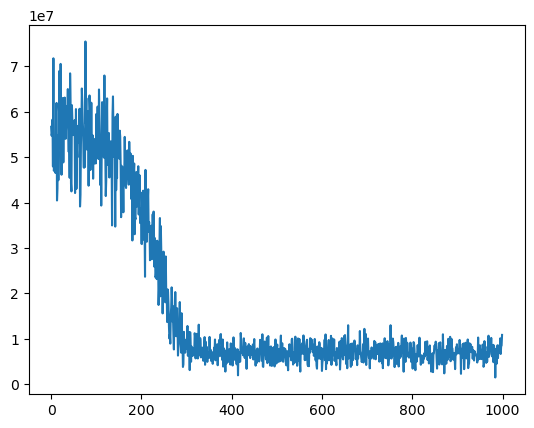

In [22]:
loss_np = np.sqrt(np.array(loss_all))
np.save('../model/loss_state.npy', loss_np)